# СМО с взаимопомощью и без очереди (M/M/n/0)

СМО с взаимопомощью:
* Взаимопомощь между каналами обслуживания
* Если поступает заявка, когда каналы свободны, то она обслуживается всеми каналами
* Если поступает заявка числом меньше каналов, то она обслуживается частью каналов
* Если поступает заявка в момент, когда обслуживаются заявки числом меньше, чем (число каналов + число мест в очереди), то она встает в очередь
* В остальных случаях заявка покидает систему

СМО без очереди:
* Не учитывается очередь

Состояния системы:
* $S_0$ - состояние, когда все каналы свободны
* $S_1$ - состояние, когда одна заявка обслуживается всеми n каналами
* $S_2$ - состояние, когда две заявки обслуживаются всеми n каналами

...

* $S_n$ - состояние, когда n заявки обслуживаются n каналами

Параметры:
* $n$ - кол-во каналов
* $\lambda$ - интенсивность потока заявок
* $\mu_n = n\mu$ - интенсивность потока обслуживания заявки

## Дискретно-событийное моделирование

In [1]:
import numpy as np

In [2]:
def get_process(time_between_events, **params):
    """
    Собирает события из процесса СМО
    Returns:
        tuple: пара списков (список со временем прибытий заявок и список со временем уходов заявок по завершении обслуживания)
    """
    assert np.all(time_between_events>0)
    
    l = params['l'] 
    mu = params['mu']
    n = params['channels']
    
    t = np.cumsum(time_between_events)
    c = [t[0]+ np.random.exponential(scale = 1/mu)]
    while t.size>1:
        # queries_nb = np.argmin(c[-1]>t) + 1
        # event = min(queries_nb, n) - 1
        
        queries_nb = np.argmin(c[-1]>t)
        if queries_nb==0:
            queries_nb = len(t)
        
        event = min(queries_nb, n) - 1
        
        # print(queries_nb)
        # print(event)
        
        if queries_nb>n:
            # print(np.arange(n, queries_nb))
            t = np.delete(t, np.arange(n, queries_nb))
            if t.size<=1:
                continue
        
        
        # print(t.size)
        # print(c[-1])
        # print(t)
        # print(len(c))
        # print()
        assert event>=0
        handling_time = np.random.exponential(scale = 1/mu)
        c_i = (t[1] + handling_time) if event == 0 else (c[-1] + handling_time)
        c.append(c_i)
        t=np.delete(t, 0)
    return np.cumsum(time_between_events), np.array(c)

In [340]:
def get_events(t,c, rejects = False,  **params):
    """
    Выдает последовательность состояний
    """
    n = params['channels']
    events = [0,]
    t, c = t.copy(), c.copy()
    np.delete(t, 0)
    
    while t.size!=0 or c.size!=0:
        if t.size==0:
            # print(c[0])
            max_index = 1
        elif c.size==0:
            # print(c[0])
            max_index = 0
        else:
            # print(t[0], c[0])
            max_index = np.argmin([t[0], c[0]])
        if max_index:
            events += [events[-1]-1]
            c = np.delete(c,0)
        else:
            events += [min(events[-1]+1, n)]
            t = np.delete(t,0)
        # print(events[-1])
        assert events[-1]>=0
    
    return np.array(events)

In [341]:
def get_rejects_nb(events, **params):
    max_state = params['channels']
    max_indices = np.squeeze(np.argwhere(events == max_state), axis = -1)
    # max_indices = np.array(max_indices)
    shifted_max_indices = np.roll(max_indices, -1)
    if shifted_max_indices.size == 0:
        return 0
    shifted_max_indices[-1] = -1
    return np.sum(max_indices + 1 == shifted_max_indices)

In [535]:
channels = 10
l = 2
mu = 0.1
mu = channels*mu

params = {
'channels': channels,
'l': l,
'mu': mu,
'samples': 1_000,
'jobs': 5_000
}

In [536]:
print('Среднее время прихода заявки: ', 1/params['l'])
print('Среднее время обработки заявки: ', 1/params['mu'])

Среднее время прихода заявки:  0.5
Среднее время обработки заявки:  1.0


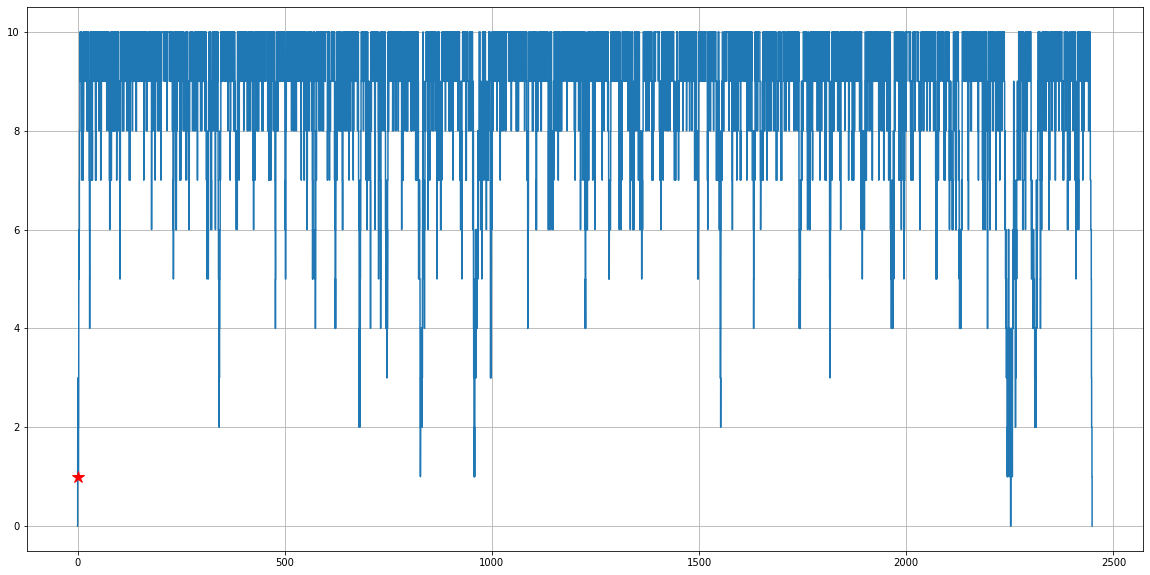

In [665]:
import matplotlib.pyplot as plt

time_between_jobs = np.random.exponential(scale = 1/params['l'], size = params['jobs'])
t,c = get_process(time_between_jobs, **params)
events = get_events(t,c, **params)
t,c, len(t), len(c), events

x = np.concatenate((t,c))
x.sort()
x = np.concatenate([x, [np.inf]])
y = events

if x[0]!=0:
    x = np.concatenate([[0],x])
    y = np.concatenate([[0], y])

point = 2.0

plt.figure(figsize = [20,10])
plt.step(x,y)
plt.plot(point, y[np.argmin(point>x)], 'r*', markersize = 12)
plt.grid()
plt.show()

In [686]:
class FrequencyFunc():
    def __init__(self, **params):
        self.params = params
    
    def simulate(self):
        self.t, self.c, self.events = [], [], []
        for _ in range(params['samples']):
            l, size = self.params['l'], self.params['jobs']
            time_between_jobs = np.random.exponential(scale = 1/l, size = size)
            t,c = get_process(time_between_jobs, **(self.params))
            events = get_events(t,c, **params)
            self.t.append(t)
            self.c.append(c)
            self.events.append(events)
        
    def __call__(self, t_current):
        assert t_current>=0
        
        states = np.zeros(self.params['channels']+1)
        
        for i in range(self.params['samples']):
            t, c, events = self.t[i], self.c[i], self.events[i]
            
            x = np.concatenate((t,c))
            x.sort(kind='mergesort')
            x = np.concatenate([x, [np.inf]])
            y = events
            
            if x[0]!=0:
                x = np.concatenate([[0],x])
                y = np.concatenate([[0], y])
            
            state = y[np.argmin(t_current>x)]
            states[state] += 1
        # print(states/params['samples'])
        # print()
        return states/self.params['samples']
    
    def get_rejects_frequency(self):
        rejects_nb = []
        t_nb = []
        for t, c, events in zip(self.t, self.c, self.events):
            # t = t[t<=right_boundary]
            # c = c[c<=right_boundary]
            # print(t.size)
            # print(c.size)
            # events = get_events(t, c, **self.params)
            rejects_nb += [get_rejects_nb(events, **self.params)/t.size]
            # rejects_nb += [get_rejects_nb(events, **self.params)]
            t_nb += [t.size]
        # return np.sum(rejects_nb)/np.sum(t_nb)
        return np.mean(rejects_nb)
    
    def get_step_points(self):
        points_x, points_y = [], []
        for t, c in zip(self.t, self.c):
            x = np.concatenate((t,c))
            x.sort()
            x = np.concatenate([x, [np.inf]])
            y = events

            if x[0]!=0:
                x = np.concatenate([[0],x])
                y = np.concatenate([[0], y])
            
            points_x+=[x]
            points_y+=[y]
        return points_x, points_y
    
    def capacity_test(self, range_boundary = 100):
        capacity = []
        for c in self.c:
            capacity += [np.mean([np.sum(np.logical_and(c>=left_boundary, c<left_boundary+1)) for left_boundary in range(0, range_boundary)])]
        return np.mean(capacity)

    # def get_downtime(self):
    #     events[events==0].size/ for events in self.events

In [687]:
freq_func = FrequencyFunc(**params)
freq_func.simulate()

(11, 301)


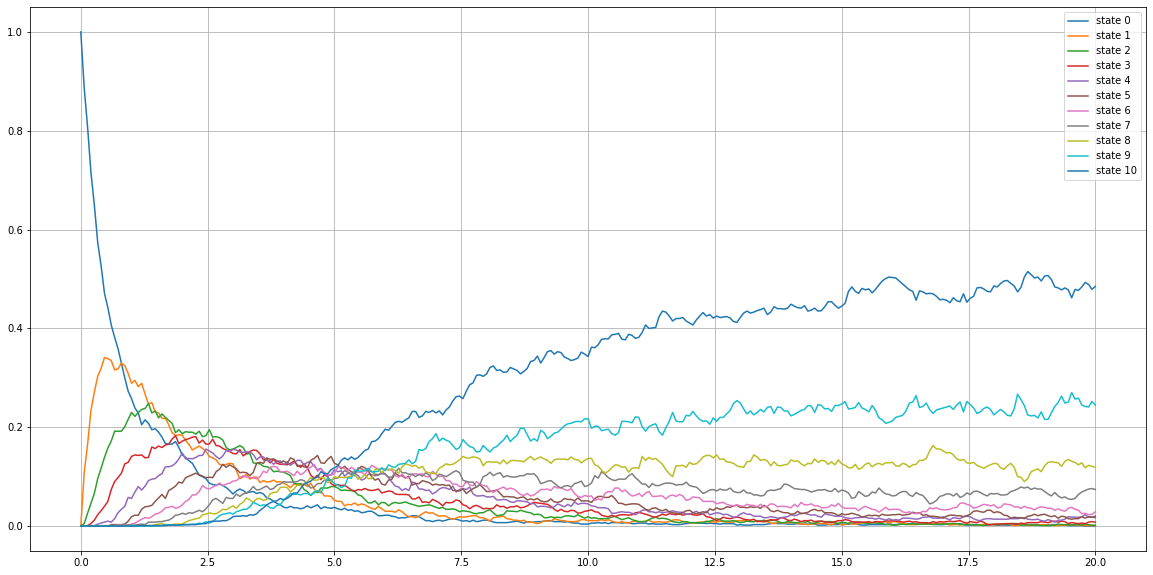

In [688]:
points = np.linspace(0, 20, 301)
frequencies = []
for point in points:
    frequency = freq_func(point)
    frequencies.append(frequency)

frequencies = np.array(frequencies).T
print(frequencies.shape)
plt.figure(figsize = [20,10])
for i,state_prediction in enumerate(frequencies):
    plt.plot(points, state_prediction, label = f'state {i}')
plt.grid()
plt.legend()
plt.show()

In [689]:
def capacity_test(self, range_boundary = 20):
    capacity = []
    for c in self.c:
        capacity += [np.mean([np.sum(np.logical_and(c>=left_boundary, c<left_boundary+1)) for left_boundary in range(0, range_boundary)])]
    return np.mean(capacity)

In [692]:
print('Вероятность отказа: ', freq_func.get_rejects_frequency())
print('Относительная пропускная способность: ', 1-freq_func.get_rejects_frequency())
print('Абсолютная пропускная способность: ', freq_func.capacity_test(500))

Вероятность отказа:  0.498495
Относительная пропускная способность:  0.501505
Абсолютная пропускная способность:  0.996706


## Источники
* https://cyclowiki.org/wiki/%D0%A1%D0%9C%D0%9E_%D1%81_%D0%B2%D0%B7%D0%B0%D0%B8%D0%BC%D0%BE%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E
*https://cyclowiki.org/wiki/%D0%97%D0%B0%D0%BC%D0%BA%D0%BD%D1%83%D1%82%D0%B0%D1%8F_%D0%A1%D0%9C%D0%9E_%D0%B1%D0%B5%D0%B7_%D0%BE%D1%87%D0%B5%D1%80%D0%B5%D0%B4%D0%B8#:~:text=%D0%A1%D0%9C%D0%9E%20%D0%B7%D0%B0%D0%BC%D0%BA%D0%BD%D1%83%D1%82%D0%B0%D1%8F%20%D0%B1%D0%B5%D0%B7%20%D0%BE%D1%87%D0%B5%D1%80%D0%B5%D0%B4%D0%B8%20%E2%80%94%20%D1%8D%D1%82%D0%BE,%D0%BF%D0%BE%D1%82%D0%BE%D0%BA%20%D0%B7%D0%B0%D1%8F%D0%B2%D0%BE%D0%BA%20%D0%BE%D1%82%20%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%B8%D1%81%D1%82%D0%BE%D1%87%D0%BD%D0%B8%D0%BA%D0%B0.
* https://studref.com/365794/agropromyshlennost/sistemy_massovogo_obsluzhivaniya_vzaimopomoschyu